In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy

import os 
import pandas as pd 

from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import pickle 

import torchvision.transforms as TT 

In [2]:
# Will display a corresponding image and bounding boxes / predictions made for it 
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [3]:
TRAIN_SEGMENTATION = "SegmentationMaps/train"
VAL_SEGMENTATION = "SegmentationMaps/valid"
TEST_SEGMENTATION = "SegmentationMaps/test"

In [4]:
seg_df = pd.read_csv(f"{TRAIN_SEGMENTATION}/_classes.csv")
seg_df.head() 

pixel_maps = {} 
for i in seg_df.T:
    row = seg_df.loc[i] 
    val = row['Pixel Value'] 
    cl = row[' Class'] 
    pixel_maps[cl] = val 
print(pixel_maps)     

{' background': 0, ' Road': 1}


In [5]:
"""
    Problem - what we are comparing / solving - need to compare something :O 
    
    Description of approach 
    
    Experiments / Comparisons 
    
    

"""
def augment_pair(img, m_img): 
    crop = TT.GaussianBlur((3,3)) 
    i1 = crop.forward(img)
    i2 = crop.forward(img) 
    
    show(i1)
    show(i2) 

t = seg_training_dl[0]
augment_pair(t[0].squeeze(0),t[1].squeeze(0))

NameError: name 'seg_training_dl' is not defined

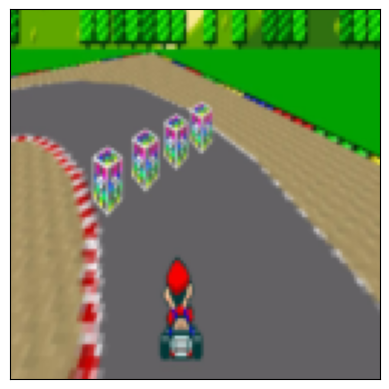

In [6]:
class SegDL(Dataset):
    def __init__(self, lof_mappings):
        self.lof_mappings = lof_mappings 
    def __len__(self):
        return len(self.lof_mappings) 
    
    def __getitem__(self, idx):
        pair = self.lof_mappings[idx] 
        return pair 


resize_factor = T.Resize((128,128), antialias=True)
def clean_image(img):    
    img = resize_factor.forward(img)  
    img = TT.ConvertImageDtype(torch.float32).forward(img) 
    img = img.unsqueeze(0) 
    return img 
    
def create_segmentation_dl_obj(PATH):
    lof_images = [] 
    for file in os.listdir(PATH):
        if '.csv' not in file and '_mask' not in file:
            mask_file = file.replace(".jpg", "") 
            mask_file = f"{mask_file}_mask.png" 
        
            img = read_image(f"{PATH}/{file}",ImageReadMode.RGB )
            img = clean_image(img) 
            
            m_img = read_image(f"{PATH}/{mask_file}")
            m_img = clean_image(m_img) 
            
            lof_images.append((img, m_img))
             
    return SegDL(lof_images)  
seg_training_dl = create_segmentation_dl_obj(TRAIN_SEGMENTATION)
seg_val_dl = create_segmentation_dl_obj(VAL_SEGMENTATION)
seg_test_dl = create_segmentation_dl_obj(TEST_SEGMENTATION)
show(seg_training_dl[0][0].squeeze(0))

In [7]:

class MarioSegmentation(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self.acc_metric = BinaryAccuracy()
        self.criterion = nn.BCELoss()
        
        self.first_downsample = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(32), 
            nn.ReLU(True) , 
        )

        self.second_downsample = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(64), 
            nn.ReLU(True)  
        )

        self.third_downsample = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128), 
            nn.ReLU(True) , 
        )


        self.first_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(64), 
          nn.ReLU(True) , 
        )

        self.second_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=64, out_channels=32,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(32), 
          nn.ReLU(True) , 
        )

        self.third_upsample =  nn.Sequential( 
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(16), 
          nn.ReLU(True) , 
        )
        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),  
        )
         
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self.forward(x) 
        loss = self.criterion(y_pred, y.float())
        self.log("train_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("train_acc", acc, prog_bar=True)
        return loss     
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self.forward(x) 
        loss = self.criterion(y_pred, y.float())
        self.log("val_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("val_acc", acc, prog_bar=True)
        return loss
 
    def forward(self, x):
        first_downsample = self.first_downsample(x) 
        second_downsample = self.second_downsample(first_downsample) 

        third_downsample = self.third_downsample(second_downsample) 


        first_upsample = self.first_upsample(third_downsample)

        merge = first_upsample  + second_downsample 

        second_upsample = self.second_upsample(merge) 

        merge = second_upsample + first_downsample 
        third_upsample = self.third_upsample(merge) 
        result = self.final_layer(third_upsample) 

        return nn.Sigmoid()(result)   


# Creating dataloader objects for these! 
model = MarioSegmentation() 

In [8]:
trainer = pl.Trainer(max_epochs=10,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=seg_training_dl, val_dataloaders=seg_val_dl) 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type           | Params
-----------------------------------------------------
0 | acc_metric        | BinaryAccuracy | 0     
1 | criterion         | BCELoss        | 0     
2 | first_downsample  | Sequential     | 960   
3 | second_downsample | Sequential     | 18.6 K
4 | third_downsample  | Sequential     | 74.1 K
5 | first_upsample    | Sequential     | 73.9 K
6 | second_upsample   | Sequential     | 18.5 K
7 | third_upsample    | Sequential     | 4.7 K 
8 | final_layer       | Sequential     | 17    
-----------------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.763     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 30.35it/s, v_num=104, train_acc=0.959]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  46%|████████████████████████████████████████████████████████████████▌                                                                           | 36/78 [00:00<00:00, 57.63it/s]


Validation DataLoader 0:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 75/78 [00:01<00:00, 60.29it/s]


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.45it/s, v_num=104, train_acc=0.979, val_acc=0.970]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  42%|███████████████████████████████████████████████████████████▏                                                                                | 33/78 [00:00<00:00, 70.54it/s]


Validation DataLoader 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 72/78 [00:01<00:00, 71.72it/s]


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 32.50it/s, v_num=104, train_acc=0.982, val_acc=0.972]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|█████████████████████████████████████████████████████▊                                                                                      | 30/78 [00:00<00:00, 64.45it/s]


Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69/78 [00:01<00:00, 67.68it/s]


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 31.06it/s, v_num=104, train_acc=0.978, val_acc=0.973]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  35%|████████████████████████████████████████████████▍                                                                                           | 27/78 [00:00<00:00, 64.48it/s]


Validation DataLoader 0:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66/78 [00:00<00:00, 68.53it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.43it/s, v_num=104, train_acc=0.987, val_acc=0.974]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  31%|███████████████████████████████████████████                                                                                                 | 24/78 [00:00<00:00, 74.46it/s]


Validation DataLoader 0:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63/78 [00:00<00:00, 73.83it/s]


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 32.56it/s, v_num=104, train_acc=0.990, val_acc=0.973]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  27%|█████████████████████████████████████▋                                                                                                      | 21/78 [00:00<00:00, 64.63it/s]


Validation DataLoader 0:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 60/78 [00:00<00:00, 65.06it/s]


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.89it/s, v_num=104, train_acc=0.992, val_acc=0.975]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  23%|████████████████████████████████▎                                                                                                           | 18/78 [00:00<00:00, 72.55it/s]


Validation DataLoader 0:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 57/78 [00:00<00:00, 72.27it/s]


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 33.41it/s, v_num=104, train_acc=0.987, val_acc=0.974]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  19%|██████████████████████████▉                                                                                                                 | 15/78 [00:00<00:00, 74.92it/s]


Validation DataLoader 0:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 54/78 [00:00<00:00, 72.23it/s]


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 30.36it/s, v_num=104, train_acc=0.993, val_acc=0.972]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  15%|█████████████████████▌                                                                                                                      | 12/78 [00:00<00:00, 70.44it/s]


Validation DataLoader 0:  65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                | 51/78 [00:00<00:00, 63.14it/s]


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 32.19it/s, v_num=104, train_acc=0.993, val_acc=0.973]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|████████████████▎                                                                                                                            | 9/78 [00:00<00:01, 64.83it/s]


Validation DataLoader 0:  62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                     | 48/78 [00:00<00:00, 66.62it/s]


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s, v_num=104, train_acc=0.993, val_acc=0.974]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s, v_num=104, train_acc=0.993, val_acc=0.974]


In [9]:
if True:
    print("Saving model to pickle")
    torch.save(model.state_dict(), "segmentation_model_weights") 


Saving model to pickle


In [10]:
rescale_factor = T.Resize((128,128), antialias=True)


In [11]:
def clean_test_image(img):
    img = TT.ConvertImageDtype(torch.float32).forward(img) 

    
    size = T.functional.get_image_size(img)
    width, height = size
    
    img = T.functional.crop(img, int(height/3), int(width/4), int(height/2), int(width/2)) 
    img = resize_factor.forward(img)     

    img = img.unsqueeze(0) 
    return img 
    

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


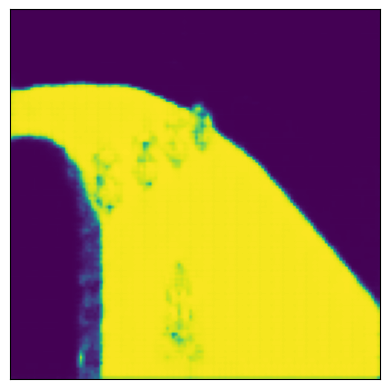

In [12]:
test_image = seg_training_dl[0][0] 

out = model.forward(test_image) 
print(out.shape) 
print(out.shape) 
out = out.squeeze(0)

show(out) 

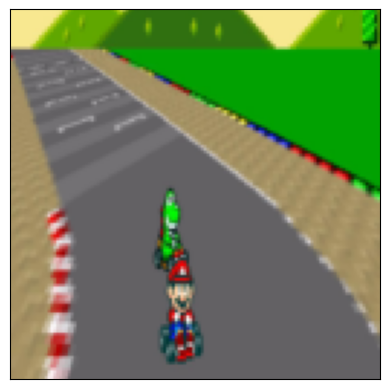

In [15]:
pred_images = [] 

for batch in seg_test_dl:
    img = batch[0]
    # 1 if it is predicted to be > .5 for the road, otherwise 0 
    show(img.squeeze(0))
    break 
    preds = model.forward(img).squeeze(0) 
    preds = preds > .5
    preds = preds.float() 
    pred_images.append(preds)


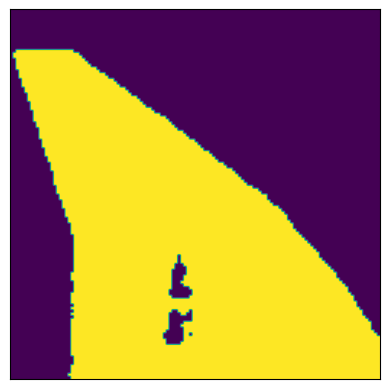

In [14]:
test = pred_images[0]
show(test) 

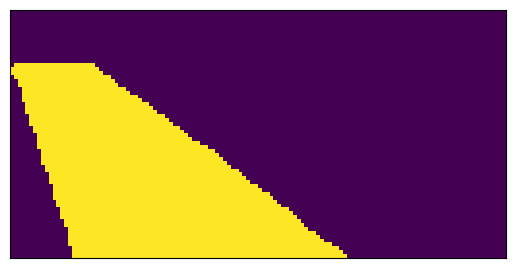

In [19]:
# Divide horizontally 
top_half = torch.hsplit(test, 2)[0]

show(top_half) 

In [ ]:
thirds = torch.tensor_split(top_half, 3, dim=2)
for t in thirds:
    show(t) 

In [ ]:

# Divided area into three sections, where each section corresponds to a location we can move to 
directions = {'a':thirds[0], 'w':thirds[1],'d':thirds[2]} 

optimal_direct = None
optimal_score = None 
totalSum = 0 

for key in directions:
    key_score = torch.sum(directions[key])
    totalSum += key_score
    if optimal_direct is None or optimal_score < key_score:
        optimal_direct = key
        optimal_score = key_score
print((optimal_score / totalSum - 0.6) * 10) 
print(f"We should press the {optimal_direct} key!")

#tensor(0.6753)
#0.6141
#0.6230

In [ ]:
test = pred_images[0] 
show(test)

In [19]:

# for _ in range(10):
#     eroded = cv2.erode(eroded, element)
# # print(cv2.countNonZero(np.array(test)) )
# plt.imshow(eroded) 

In [20]:
import cv2 
# test = np.array(test) 
test = pred_images[0] 
test = F.to_pil_image(test)
test = np.array(test) 

In [21]:
# test = close_gaps(test) 
test = cv2.ximgproc.thinning(test) 

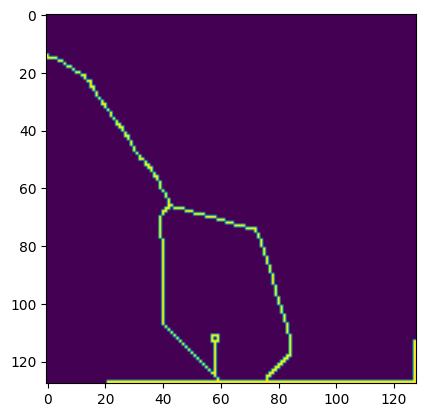

In [22]:
from matplotlib import pyplot as plt

plt.imshow(test) 

array([1.6010538], dtype=float32)

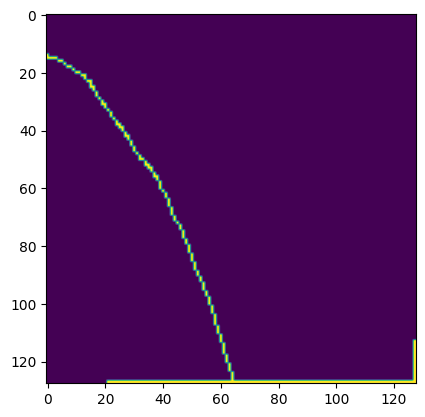

In [23]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))

def close_gaps(img):
    test = F.to_pil_image(img) 
    eroded = np.array(test) 
    
    eroded = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel)

#     eroded = cv2.morphologyEx(eroded, cv2.MORPH_GRADIENT, kernel)
    
    return eroded  


def fill_shape(test):
    points = cv2.findNonZero(test)
    
    filled = cv2.fillConvexPoly(test, points, 255)
    return filled  

def calculate_direction(img):
    test = F.to_pil_image(img)
    test = np.array(test) 
    test = fill_shape(test)
#     plt.imshow(test)
#     plt.imshow(test)

    test = cv2.ximgproc.thinning(test)
    plt.imshow(test)

#     plt.imshow(test) 
    points = cv2.findNonZero(test) 
    
    
    
    
    vx, vy,xo,yo = cv2.fitLine(points, cv2.DIST_L1, 0, 0.01, 0.01) 
#     contours, hierarchy = cv2.findContours(test, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     print(contours) 
#     plt.imshow(test) 
    return vy / vx  


calculate_direction(pred_images[0]) 

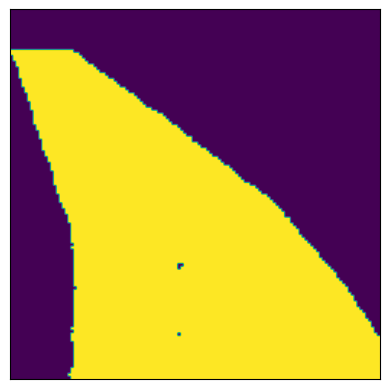

In [24]:
show(pred_images[0]) 


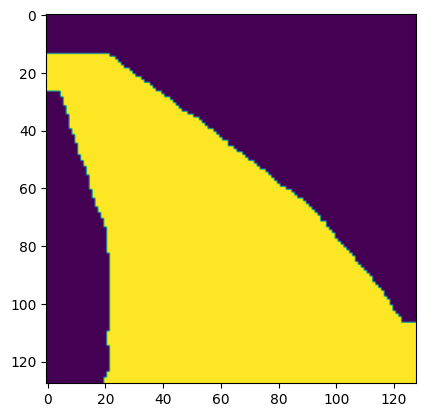

In [25]:
plt.imshow(close_gaps(pred_images[0])) 

array([1.6010538], dtype=float32)

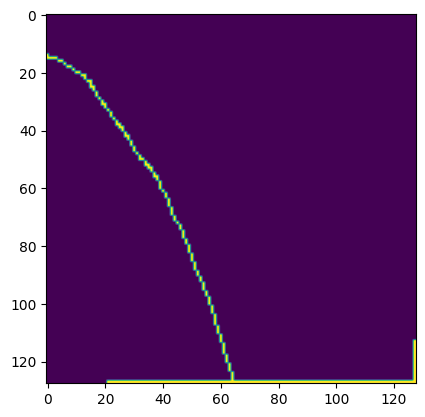

In [26]:
calculate_direction(pred_images[0]) 

In [27]:

# idx = 30

# path = test_images[idx] 
# path = "Images/s_32.png"
# # img = read_image(f"Images/{test_images[idx]}", ImageReadMode.RGB)
# img = read_image(f"{path}", ImageReadMode.RGB)

# img = clean_test_image(img) 
# show(img.squeeze(0)) 

# out = model.forward(img)

# out = out.float()
# out = out.squeeze(0)

# out = out > 0.7
# out = out.float() 

# show(out) 
# print(calculate_direction(out))
 

s_10.png


array([-1.5089469], dtype=float32)

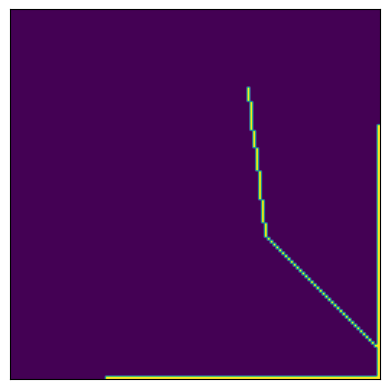

In [28]:
idx = 20
test_images = [] 
for file in os.listdir("Images/"):
    test_images.append(file) 


idx = 7

# for idx in range(len(test_images)):
print(test_images[idx]) 
img = read_image(f"Images/{test_images[idx]}", ImageReadMode.RGB)
img = clean_test_image(img) 
 
# show(img.squeeze(0)) 

out = model.forward(img)

out = out.float()
out = out.squeeze(0)

out = out > 0.5
out = out.float() 


show(out) 

calculate_direction(out) 





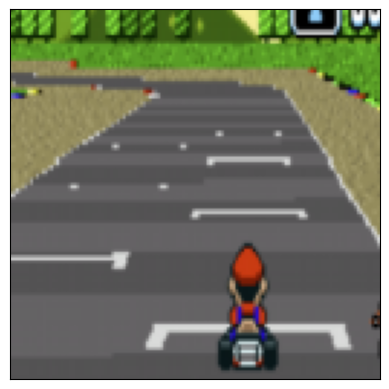

In [33]:
def clean_test_other_image(path):
    img = read_image(path, ImageReadMode.RGB)
    img = TT.ConvertImageDtype(torch.float32).forward(img) 
    
    size = T.functional.get_image_size(img)
    width, height = size
    
#     img = T.functional.crop(img, int(height/3), int(width/4), int(height/2), int(width/2)) 
    img = resize_factor.forward(img)     

    img = img.unsqueeze(0) 
    return img 

img = clean_test_other_image("test.png") 
show(img.squeeze(0)) 

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

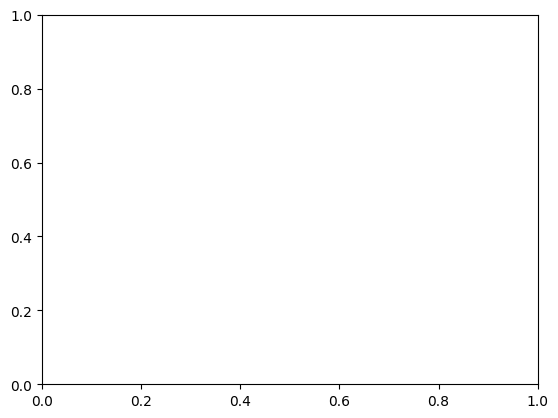

In [35]:
out = model.forward(img)

out = out.float()
out = out.squeeze(0)

out = out > 0.5
out = out.float() 


show(close_gaps(out)) 